In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('ab_data.csv')
data.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


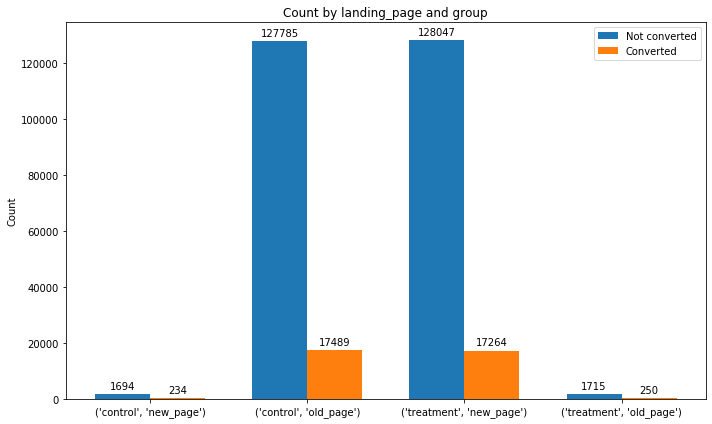

In [3]:
groups = data.pivot_table(index=['group', 'landing_page', 'converted'], values='user_id', aggfunc='count').unstack()
labels = groups.index
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, groups[('user_id', 0)], width, label='Not converted')
rects2 = ax.bar(x + width/2, groups[('user_id', 1)], width, label='Converted')

ax.set_ylabel('Count')
ax.set_title('Count by landing_page and group')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

В данных присутствуют некорректные события показов контрольной группе новой страницы и тестовой группе - старой страницы. Очищаем выборку от таких событий.

In [4]:
cleaned_data = data[((data['group']=='control') & (data['landing_page']=='old_page')) |
                      ((data['group']=='treatment') & (data['landing_page']=='new_page'))].reset_index(drop=True)
print(data.shape, cleaned_data.shape)
cleaned_data[cleaned_data['user_id'].duplicated()]

(294478, 5) (290585, 5)


,user_id,timestamp,group,landing_page,converted
2862,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [5]:
cleaned_data = cleaned_data.drop_duplicates(subset='user_id')
print(cleaned_data.shape)

(290584, 5)


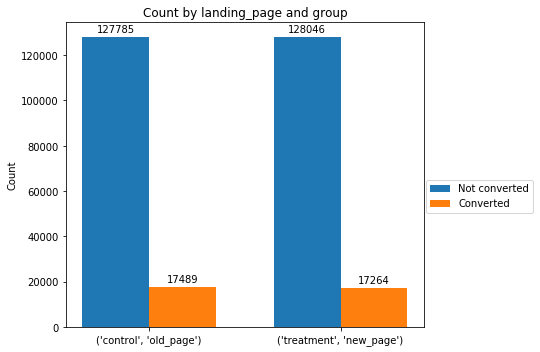

In [6]:
groups = cleaned_data.pivot_table(index=['group', 'landing_page', 'converted'], values='user_id', aggfunc='count').unstack()
labels = groups.index
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, groups[('user_id', 0)], width, label='Not converted')
rects2 = ax.bar(x + width/2, groups[('user_id', 1)], width, label='Converted')

ax.set_ylabel('Count')
ax.set_title('Count by landing_page and group')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(bbox_to_anchor=(1.32, 0.5))

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

## 1. Evaluate normality

In [7]:
groups.columns = ['CLICK_0', 'CLICK_1']
groups['TOTAL'] = groups.sum(axis=1)
groups['CTR'] = groups['CLICK_1'] / groups['TOTAL']

In [8]:
groups

,,CLICK_0,CLICK_1,TOTAL,CTR
group,landing_page,,,,
control,old_page,127785,17489,145274,0.120386
treatment,new_page,128046,17264,145310,0.118808


In [9]:
Na = groups.loc['control', 'TOTAL'].values  # число всех опытов серии control
Nb = groups.loc['treatment', 'TOTAL'].values  # число всех опытов серии treatment

Na1 = groups.loc['control', 'CLICK_1'].values  # число успехов серии control
Nb1 = groups.loc['treatment', 'CLICK_1'].values  # число успехов серии treatment

N = Na + Nb  # всего число опытов
N1 = Na1 + Nb1  # всего число успехов

Pa = Na1 / Na
Pb = Nb1 / Nb
P = N1 / N

In [10]:
T = ((Pa - Pb) / np.sqrt(P * (1 - P) * (1 / Na + 1 / Nb)))[0]
alpha = 0.05

print('t_alpha =', stats.norm.ppf(alpha))
print('T =', T)
print('')
print('\033[1m\033[91m_____крит_область______[t_alpha]\033[92m_________[T]__________\033[0m')

t_alpha = -1.6448536269514729
T = 1.3109241984234394

_____крит_область______[t_alpha]_________[T]__________


- T принадлежит доверительной области, значит на уровне достоверности alpha=0.05 принимаем H0: значения CTR не различаются

In [11]:
p_value = 1 - stats.norm.cdf(T)

print('p_value', p_value)
print('alpha', alpha)
print('p_value > alpha:', p_value > alpha)

p_value 0.09494168724097551
alpha 0.05
p_value > alpha: True


- p_value > alpha, поэтому на уровне достоверности alpha=0.05 принимаем H0: значения CTR не различаются
- при этом p_value близко к alpha, поэтому уверенность в H0 не высока